# Declaring necessary imports 

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import scipy.stats as stats

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score
from scipy.io import arff
from pylab import bone, pcolor, colorbar

# Function for builiding AutoEncoder model

In [2]:
def autoencoder_function(nv, nh, optimizer='adam', loss='mean_squared_error', metrics=['accuracy']):
    """
    Main function to define the AE Neural Network.
    
    Parameters
    ----------
    nv: TYPE
    DESCRIPTION.
    nh : TYPE
    DESCRIPTION.
    optimizer : TYPE, optional
    DESCRIPTION. The default is "adam".
    loss : TYPE, optional
    DESCRIPTION. The default is 'mean_squared_error'.
    metrics : TYPE, optional
    DESCRIPTION. The default is ['accuracy'].
    
    Returns
    -------
    autoencoder: TYPE.
        DESCRIPTION.
    """
    
    #Define input
    input_layer = Input(shape=(nv,))
    
    #Encoding
    encoder = Dense(nh, activation='relu', activity_regularizer=regularizers.l1(10e-5)) (input_layer)
    
    #Decoding
    decoder = Dense(nv, activation='sigmoid') (encoder)
    
    #Model
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return autoencoder
    

# Defining SOM

In [23]:
class SOM():
    def __init__(self, m, n, dim, num_iterations=1, learning_rate=0.5, sigma=None):
        self._m = m
        self._n = n
        self._neighborhood = []
        self._topography = []
        self._num_iterations = int(num_iterations)
        self._learned = False
        self.dim = dim
        self.d = 0
        
        if sigma is None:
            sigma = max(m, n)/2.0 # Constant radius
        else:
            sigma = float(sigma)
            
        self.learning_rate = learning_rate
        self.learning_rate_0 = learning_rate
        self.sigma = sigma
        self.sigma_0 = sigma
        
        print('Network created with dimensions', m, n)
        
        #Weight Matrix and the topography of neurons
        self._W = tf.random.normal([m*n, dim], seed=0)
        
        #Topography nos define un array de (30x30) x 2 (900 x 2) donde cada fila representa las coordenadas en el
        #mapa de esa unidad. Por ejemplo la unidad 5 de la lista esta en las coordenadas [0,5], la 200 en la [6, 20]
        #y la ultima es la [30, 30]
        self._topography = np.array(list(self._neuron_location(m, n)))
        
    #Funcion para generar las posiciones en la malla para un array de unidades
    def _neuron_location(self, m, n):
        for i in range(m):
            for j in range(n):
                yield np.array([i,j])
                
    def training(self, x, i):
        m = self._m
        n = self._n
        
        #1. Obtencion de las distancias y seleccion de BMU(idx)
        d = tf.sqrt(tf.reduce_sum(tf.pow(self._W - tf.stack([x for i in range(m*n)]), 2), 1))
        self.BMU_idx = tf.argmin(d, 0)
        self.d = d
        
        #2. Obtener BMU para el idx
        self.BMU_loc = self._topography[self.BMU_idx]
        
        #3. Actualizar sigma y learning rate
        lambda_coeff = self._num_iterations/self.sigma_0
        learning_rate = self.learning_rate_0*np.exp(-1/lambda_coeff)
        sigma = self.sigma_0*np.exp(-1/lambda_coeff)
        
        #4. Calcular b_ij
        beta_ij = np.exp((-d**2)/(2*sigma**2))
        
        #5. Eligir vecinos
        neighbs = [self._check_point(p[0], p[1], self.BMU_loc[0], self.BMU_loc[1], sigma) for p in self._topography]
        
        #6. Coeficiente para actualizar pesos
        weight_multiplier = tf.math.multiply(beta_ij, neighbs)
        weight_multiplier = tf.math.multiply(learning_rate, weight_multiplier)
        
        #7. Valor para actualizar pesos
        delta_W = tf.subtract(tf.stack([x for i in range(m*n)]), self._W)
        weight_multiplier = tf.stack([weight_multiplier for i in range(n_dim)], axis=1)
        update_value = tf.multiply(weight_multiplier, weight_multiplier)
        update_value = tf.multiply(weight_multiplier, delta_W)
        
        #8. Actualización pesos
        new_W = self._W + update_value
        self._w = new_W
        
    #Comprobar si un punto esta dentro del radio alrededor del otro
    def _check_point(self, x, y, center_x, center_y, radius):
        check = (x - center_x)**2 + (y - center_y)**2 < radius**2
        if check == True:
            return 1
        else:
            return 0
        
    def fit(self, X):
        #Preparar datos de entrada
        np.random.shuffle(X)
        X = tf.cast(X, tf.float32)
        
        #Iteraciones
        for i in range(self._num_iterations):
            for x in X:
                self.training(x, i)
                
        #Guardar información
        self._Wts = list(self._w)
        self._locations = list(self._topography)
        self._learned = True
        
    def winner(self, X):
        if not self._learned:
            raise ValueError('SOM not trained yet')
            
        return self.BMU_loc.numpy()
    
    def map_vects(self, X):
        if not self._learned:
            raise ValueError('SOM not trained yet')
            
        to_return = []
        for vect in X:
            min_index = min([i for i in range(len(self._Wts))], key=lambda x: np.linalg.norm(vect - self._Wts[x]))
            to_return.append(self._locations[min_index])
            
        return to_return
    
    def distance_map(self):
        if not self._learned:
            raise ValueError('SOM not trained yet')
            
        mapping = tf.reshape(self.d, shape=(self._m, self._n)).numpy()
        return mapping

# I. Preparing the data
## Loading dataset

In [4]:
data = arff.loadarff('Data_Sources/seismic-bumps.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].astype(int)
df['seismic'] = df['seismic'].str.decode('utf-8')
df['seismoacoustic'] = df['seismoacoustic'].str.decode('utf-8')
df['shift'] = df['shift'].str.decode('utf-8')
df['ghazard'] = df['ghazard'].str.decode('utf-8')
df.head()

,seismic,seismoacoustic,shift,genergy,gpuls,gdenergy,gdpuls,ghazard,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,nbumps7,nbumps89,energy,maxenergy,class
0,a,a,N,15180.0,48.0,-72.0,-72.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,a,a,N,14720.0,33.0,-70.0,-79.0,a,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2000.0,2000.0,0
2,a,a,N,8050.0,30.0,-81.0,-78.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,a,a,N,28820.0,171.0,-23.0,40.0,a,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3000.0,3000.0,0
4,a,a,N,12640.0,57.0,-63.0,-52.0,a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Label Encoding

In [5]:
df = pd.get_dummies(df, drop_first=True)
df.head()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,nbumps6,...,nbumps89,energy,maxenergy,class,seismic_b,seismoacoustic_b,seismoacoustic_c,shift_W,ghazard_b,ghazard_c
0,15180.0,48.0,-72.0,-72.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,14720.0,33.0,-70.0,-79.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,2000.0,2000.0,0,0,0,0,0,0,0
2,8050.0,30.0,-81.0,-78.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,28820.0,171.0,-23.0,40.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,3000.0,3000.0,0,0,0,0,0,0,0
4,12640.0,57.0,-63.0,-52.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


In [7]:
df['class'].value_counts()/len(df)

0    0.934211
1    0.065789
Name: class, dtype: float64

## Eliminate low variance cols

In [6]:
cols_keep = [column for column in list(df.columns) if df[column].std()>0]
df=df[cols_keep]
df.head()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy,class,seismic_b,seismoacoustic_b,seismoacoustic_c,shift_W,ghazard_b,ghazard_c
0,15180.0,48.0,-72.0,-72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
1,14720.0,33.0,-70.0,-79.0,1.0,0.0,1.0,0.0,0.0,2000.0,2000.0,0,0,0,0,0,0,0
2,8050.0,30.0,-81.0,-78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
3,28820.0,171.0,-23.0,40.0,1.0,0.0,1.0,0.0,0.0,3000.0,3000.0,0,0,0,0,0,0,0
4,12640.0,57.0,-63.0,-52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0


# II. Exploratory Data Analysis
## Plot correlation

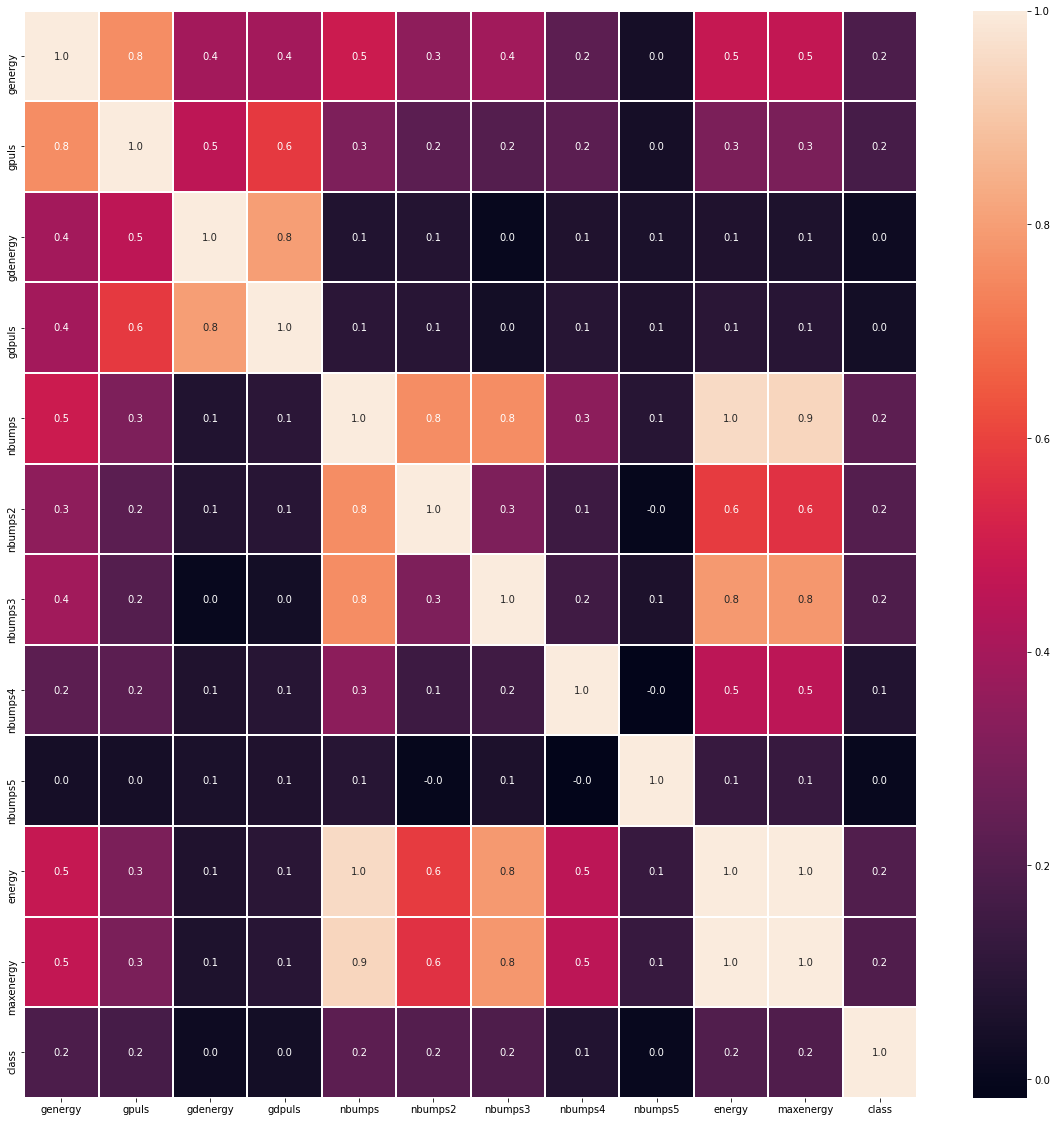

In [8]:
list_no = ['seismic_b', 'seismoacoustic_b','seismoacoustic_c', 'shift_W', 'ghazard_b', 'ghazard_c']
cols= [x for x in list(df.columns) if x not in list_no]
f, ax = plt.subplots(figsize=(20, 20))
df_plot = df[cols] #columnas que no esten en obj_df
sns.heatmap(df_plot.corr(method='spearman'), annot=True, fmt='.1f', linewidths=1, ax=ax)
plt.show()

## ANOVA

In [9]:
print('ANOVA for seismic_b')
print(stats.f_oneway(df[df['seismic_b']==0]['class'], df[df['seismic_b']==1]['class']))

print()
print('ANOVA for seismoacoustic_b')
print(stats.f_oneway(df[df['seismoacoustic_b']==0]['class'], df[df['seismoacoustic_b']==1]['class']))

print()
print('ANOVA for seismoacoustic_c')
print(stats.f_oneway(df[df['seismoacoustic_c']==0]['class'], df[df['seismoacoustic_c']==1]['class']))

print()
print('ANOVA for shift_W')
print(stats.f_oneway(df[df['shift_W']==0]['class'], df[df['shift_W']==1]['class']))

print()
print('ANOVA for ghazard_b')
print(stats.f_oneway(df[df['ghazard_b']==0]['class'], df[df['ghazard_b']==1]['class']))

print()
print('ANOVA for ghazard_c')
print(stats.f_oneway(df[df['ghazard_c']==0]['class'], df[df['ghazard_c']==1]['class']))

ANOVA for seismic_b
F_onewayResult(statistic=21.356901872363814, pvalue=3.999798007997421e-06)

ANOVA for seismoacoustic_b
F_onewayResult(statistic=0.26030552095122494, pvalue=0.6099539459472678)

ANOVA for seismoacoustic_c
F_onewayResult(statistic=0.008604018540960165, pvalue=0.9261031344898955)

ANOVA for shift_W
F_onewayResult(statistic=53.195573029878325, pvalue=3.9966222710548486e-13)

ANOVA for ghazard_b
F_onewayResult(statistic=0.0002314181198416004, pvalue=0.9878638779704311)

ANOVA for ghazard_c
F_onewayResult(statistic=2.1376059696220433, pvalue=0.14384772674207144)


## Drop columns

In [10]:
df = df.drop(columns=['maxenergy', 'nbumps'])
df.head()

,genergy,gpuls,gdenergy,gdpuls,nbumps2,nbumps3,nbumps4,nbumps5,energy,class,seismic_b,seismoacoustic_b,seismoacoustic_c,shift_W,ghazard_b,ghazard_c
0,15180.0,48.0,-72.0,-72.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
1,14720.0,33.0,-70.0,-79.0,0.0,1.0,0.0,0.0,2000.0,0,0,0,0,0,0,0
2,8050.0,30.0,-81.0,-78.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0
3,28820.0,171.0,-23.0,40.0,0.0,1.0,0.0,0.0,3000.0,0,0,0,0,0,0,0
4,12640.0,57.0,-63.0,-52.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0


## Normalize

In [11]:
sc = MinMaxScaler(feature_range = (0,1))
list_columns = list(df.columns)
df = pd.DataFrame(sc.fit_transform(df))
df.columns = list_columns
df.head()

,genergy,gpuls,gdenergy,gdpuls,nbumps2,nbumps3,nbumps4,nbumps5,energy,class,seismic_b,seismoacoustic_b,seismoacoustic_c,shift_W,ghazard_b,ghazard_c
0,0.005810,0.010186,0.017897,0.025696,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.005633,0.006864,0.019389,0.018201,0.0,0.142857,0.0,0.0,0.004975,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.003063,0.006200,0.011186,0.019272,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.011065,0.037422,0.054437,0.145610,0.0,0.142857,0.0,0.0,0.007463,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.004831,0.012179,0.024609,0.047109,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Raw dataframe

In [12]:
df_raw = df

## Plot target variable

Text(0.5, 1.0, 'Normal vs Seismic')

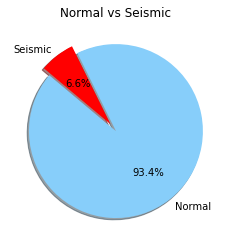

In [13]:
labels = ['Normal', 'Seismic']
sizes = [len(df_raw[df_raw['class']==0]), len(df_raw[df_raw['class']==1])]
colors = ['lightskyblue', 'red']
explode = (0, 0.1)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Normal vs Seismic')

# III. SOM 
## Train/test split

In [14]:
SOM_X = df_raw.copy().drop(columns=['class']).values # No class column
SOM_y = df_raw.iloc[:, -1].values #Class column taken as array

## Hyperparameters

In [15]:
n_dim = np.shape(SOM_X)[1]
grid_size = (10, 10)
sigma = 10
num_iterations = 50
learning_rate = 0.5

## Fit & Train

In [24]:
som = SOM(
    grid_size[0],
    grid_size[1],
    dim=n_dim,
    num_iterations=num_iterations,
    learning_rate=learning_rate,
    sigma=sigma)
som.fit(SOM_X)

Network created with dimensions 10 10


## Distance matrix with MID for each vector unit

In [25]:
distance_matrix = som.distance_map().T

## Visualize results

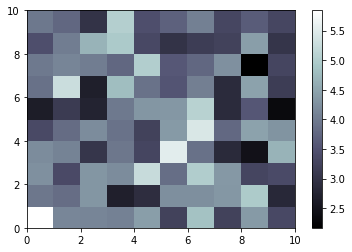

In [26]:
bone() #Initialize visualization window
pcolor(distance_matrix) #Color MID of the nodes
colorbar() #To get a legend of the representation of colors.

In [31]:
max_value = np.amax(distance_matrix)
min_value = np.amin(distance_matrix)
list_mid = list(np.reshape(distance_matrix, (grid_size[0]*grid_size[1], )))
list_mid.sort()
list_mid = [j for j in list_mid if j > 4.8]
list_idx = [np.where(distance_matrix==j) for j in list_mid]
list_idx = [[idx_max[0][0], idx_max[1][0]] for idx_max in list_idx]
mappings= som.map_vects(SOM_X)

## Detectar anomalías

In [32]:
df_quakes = pd.DataFrame()

for i, x in enumerate(SOM_X): #1 being index values, x are the vector quakes of each iteration,
#going through the data
    w = mappings[i] #BMU for the record, if the BMU equals the unit's outliers, we identify it as a potential case
    is_quake= False
    #Quake if w is inside the BMU
    if [w[0], w[1]] in list_idx:
        is_quake = True
    #Save results
    df_quakes = df_quakes.append(pd.DataFrame({
        'mapping':[w],
        'is_quake': [is_quake],
        'quake_cualification':[df_raw.iloc[i]['class']]
    }))

df_quakes[df_quakes['is_quake'] == True].head()

,mapping,is_quake,quake_cualification
0,"[8, 3]",True,0.0
0,"[8, 3]",True,0.0
0,"[8, 3]",True,0.0
0,"[8, 3]",True,0.0
0,"[8, 3]",True,0.0


## Disable eager_exec

In [33]:
tf.compat.v1.disable_eager_execution()

# IV. Supervised AE
## Train/Eval Split

In [34]:
X_train, X_test = train_test_split(df_raw, test_size=0.2, random_state=42)

## Train only in non outliers

In [35]:
X_train = X_train[X_train['class'] == 0]
X_train = X_train.drop(['class'], axis=1)
y_test = X_test['class']
X_test = X_test.drop(['class'], axis=1)
X_train = X_train.values
X_test = X_test.values

## Parameters

In [36]:
nv = X_train.shape[1] #visible units
nh = 32 #hidden units
epochs = 50
batch_size = 256

## Train AE

In [37]:
model = autoencoder_function(nv, nh, optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, shuffle=True)

Train on 1934 samples
Epoch 1/50
1934/1934 [==============================] - 0s 174us/sample - loss: 0.2217 - accuracy: 0.3263
Epoch 2/50
1934/1934 [==============================] - 0s 19us/sample - loss: 0.2126 - accuracy: 0.3263
Epoch 3/50
1934/1934 [==============================] - 0s 13us/sample - loss: 0.2036 - accuracy: 0.3278
Epoch 4/50
1934/1934 [==============================] - 0s 25us/sample - loss: 0.1942 - accuracy: 0.3299
Epoch 5/50
1934/1934 [==============================] - 0s 17us/sample - loss: 0.1844 - accuracy: 0.3294
Epoch 6/50
1934/1934 [==============================] - 0s 9us/sample - loss: 0.1740 - accuracy: 0.3278
Epoch 7/50
1934/1934 [==============================] - 0s 12us/sample - loss: 0.1633 - accuracy: 0.3175
Epoch 8/50
1934/1934 [==============================] - 0s 12us/sample - loss: 0.1521 - accuracy: 0.3185
Epoch 9/50
1934/1934 [==============================] - 0s 12us/sample - loss: 0.1409 - accuracy: 0.3428
Epoch 10/50
1934/1934 [==========

## Plot metrics


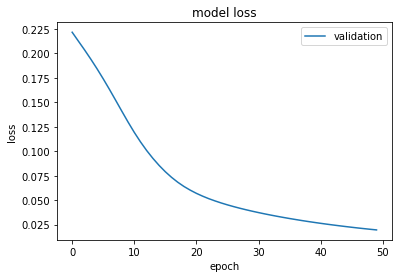

In [38]:
plt_history = history.history
plt.plot(plt_history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation'], loc='upper right')
plt.show()

## Obtain predictions

In [39]:
threshold = 0.02 # Set threshold for reconstruction error

predictions = model.predict(X_test)
se = np.mean(np.power(X_test - predictions, 2), axis = 1)
mse = np.mean(np.power(X_test - predictions, 2), axis = 1)
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_test})

/usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


## Visualize [Chart]

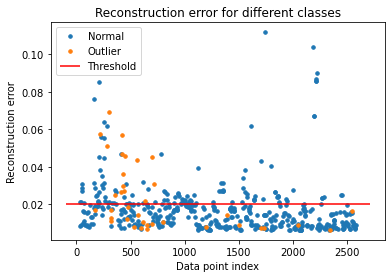

In [40]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index,
            group.reconstruction_error,
            marker='o',
            ms=3.5,
            linestyle='',
            label='Outlier' if name == 1 else 'Normal')
    
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors='r', zorder=100, label='Threshold')
ax.legend()
plt.title('Reconstruction error for different classes')
plt.ylabel('Reconstruction error')
plt.xlabel('Data point index')
plt.show()

## Visualize[CM]

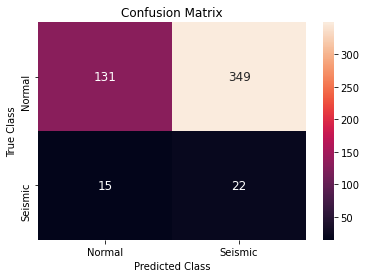

In [41]:
y_pred = [1 if e < threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', annot_kws={'fontsize':12})
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

## Other metrics

In [42]:
print('F1 score: ', f1_score(error_df.true_class, y_pred))

F1 score:  0.10784313725490197


In [43]:
model.save('models/quake_supervised_ae.h5')

# V. Unsupervised AE
## Train/Eval split

In [44]:
df_input = df_raw.copy().drop(columns=['class']) # No class column
X_train, X_test = train_test_split(df_input, test_size=0.2, random_state=42)

## Parameters

In [45]:
nv = X_train.shape[1] #visible units
nh = 32
epochs = 50
batch_size = 256

## Train AE

In [46]:
model = autoencoder_function(nv, nh, optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
history = model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, shuffle=True)

Train on 2067 samples
Epoch 1/50
2067/2067 [==============================] - 0s 36us/sample - loss: 0.2306 - accuracy: 0.3841
Epoch 2/50
2067/2067 [==============================] - 0s 14us/sample - loss: 0.2195 - accuracy: 0.4838
Epoch 3/50
2067/2067 [==============================] - 0s 18us/sample - loss: 0.2087 - accuracy: 0.5099
Epoch 4/50
2067/2067 [==============================] - 0s 21us/sample - loss: 0.1976 - accuracy: 0.5568
Epoch 5/50
2067/2067 [==============================] - 0s 16us/sample - loss: 0.1860 - accuracy: 0.6565
Epoch 6/50
2067/2067 [==============================] - 0s 18us/sample - loss: 0.1735 - accuracy: 0.6439
Epoch 7/50
2067/2067 [==============================] - 0s 10us/sample - loss: 0.1603 - accuracy: 0.6202
Epoch 8/50
2067/2067 [==============================] - 0s 11us/sample - loss: 0.1465 - accuracy: 0.5631
Epoch 9/50
2067/2067 [==============================] - 0s 11us/sample - loss: 0.1326 - accuracy: 0.5090
Epoch 10/50
2067/2067 [==========

## Obtain predictions

In [47]:
threshold = 0.02 # Set threshold for reconstruction error

predictions = model.predict(X_test)
se = np.mean(np.power(X_test - predictions, 2), axis = 1)
mse = np.mean(np.power(X_test - predictions, 2), axis = 1)
error_df = pd.DataFrame({'reconstruction_error': mse})

/usr/local/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


## Visualize [Chart]

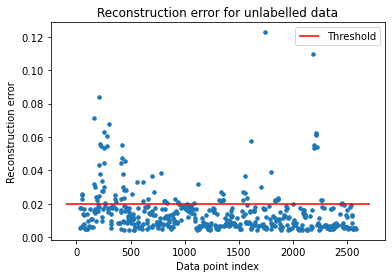

In [48]:
fig, ax = plt.subplots()

ax.plot(error_df.index, error_df.reconstruction_error, marker='o', ms=3.5, linestyle='')
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors='r', zorder=100, label='Threshold')
ax.legend()
plt.title('Reconstruction error for unlabelled data')
plt.ylabel('Reconstruction error')
plt.xlabel('Data point index')
plt.show()

In [49]:
model.save('models/quake_unsupervised_ae.h5')